# Convnet by transfer learning
- solving a small-data problem by pretrained network  
- (1) feature extraction
- (2) fine-tuning
- reference: 'deep learning with python' by f.chollet

In [1]:
import keras
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4706642291309649109
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 6814913823
locality {
  bus_id: 1
}
incarnation: 15612836334557378034
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
]


## (1) Feature extraction using pretrained network
- from VGG16 network, trained on ImageNet with 1,000 classes
- to extract intersting features from cat and dog images
- to train a cat vs. dog classifier on top of these features

In [4]:
# import the pretrained VGG16 network
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(150, 150, 3))

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [9]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/admin/Downloads/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255) # without data augumentation
batch_size = 20

In [10]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        
        i += 1
        if i*batch_size >= sample_count:
            break
            
    return features, labels

In [11]:
%%time
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Wall time: 25.6 s


In [12]:
# Flattening features before feeding into densely-connected classifier
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [14]:
# Defining a densely-connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
             loss='binary_crossentropy', 
             metrics=['acc'])

In [15]:
%%time
history = model.fit(train_features, train_labels, 
                   epochs=30, 
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 503us/step - loss: 0.5889 - acc: 0.6795 - val_loss: 0.4291 - val_acc: 0.8340
Epoch 2/30
2000/2000 [==============================] - 1s 345us/step - loss: 0.4174 - acc: 0.8120 - val_loss: 0.3680 - val_acc: 0.8420
Epoch 3/30
2000/2000 [==============================] - 1s 343us/step - loss: 0.3542 - acc: 0.8535 - val_loss: 0.3233 - val_acc: 0.8650
Epoch 4/30
2000/2000 [==============================] - 1s 337us/step - loss: 0.3141 - acc: 0.8765 - val_loss: 0.2949 - val_acc: 0.8820
Epoch 5/30
2000/2000 [==============================] - 1s 342us/step - loss: 0.2824 - acc: 0.8860 - val_loss: 0.2825 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 1s 342us/step - loss: 0.2585 - acc: 0.9000 - val_loss: 0.2691 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 1s 339us/step - loss: 0.2396 - acc: 0.9075 - val_loss: 0.2665 - val_acc: 0.8910


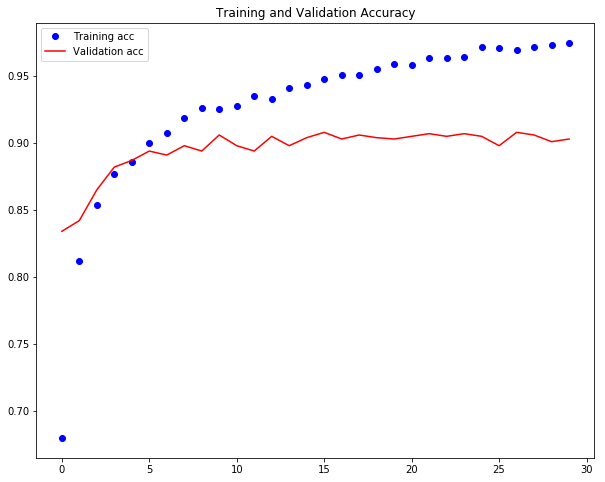

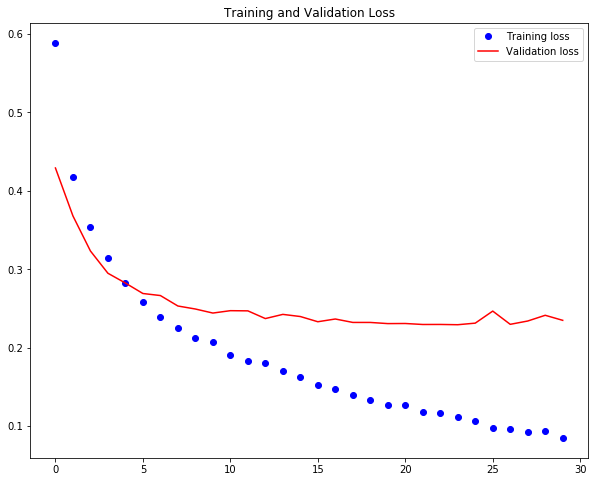

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### Extending the conv_base model and running it end-to-end on the inputs

In [30]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [32]:
# freezing a network
conv_base.trainable = False

print(len(model.trainable_weights)) # 2 layers * (the main weight matrix and the bias vector)

4


In [34]:
from keras.preprocessing.image import ImageDataGenerator

# using data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # no data augumentation

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='binary')

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
             loss='binary_crossentropy', 
             metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [35]:
%%time
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/30
 - 17s - loss: 0.5911 - acc: 0.6855 - val_loss: 0.4514 - val_acc: 0.8310
Epoch 2/30
 - 15s - loss: 0.4847 - acc: 0.7830 - val_loss: 0.3644 - val_acc: 0.8740
Epoch 3/30
 - 15s - loss: 0.4343 - acc: 0.8145 - val_loss: 0.3230 - val_acc: 0.8800
Epoch 4/30
 - 15s - loss: 0.4066 - acc: 0.8235 - val_loss: 0.3054 - val_acc: 0.8760
Epoch 5/30
 - 15s - loss: 0.3811 - acc: 0.8370 - val_loss: 0.2887 - val_acc: 0.8900
Epoch 6/30
 - 16s - loss: 0.3666 - acc: 0.8335 - val_loss: 0.2805 - val_acc: 0.8910
Epoch 7/30
 - 15s - loss: 0.3563 - acc: 0.8485 - val_loss: 0.2698 - val_acc: 0.8930
Epoch 8/30
 - 16s - loss: 0.3494 - acc: 0.8515 - val_loss: 0.2628 - val_acc: 0.9000
Epoch 9/30
 - 15s - loss: 0.3361 - acc: 0.8575 - val_loss: 0.2665 - val_acc: 0.8910
Epoch 10/30
 - 15s - loss: 0.3282 - acc: 0.8595 - val_loss: 0.2547 - val_acc: 0.9000
Epoch 11/30
 - 15s - loss: 0.3251 - acc: 0.8575 - val_loss: 0.2531 - val_acc: 0.9010
Epoch 12/30
 - 15s - loss: 0.3307 - acc: 0.8515 - val_loss: 0.2522 - val_a

In [36]:
model.save('cats_and_dogs_small_3.h5')

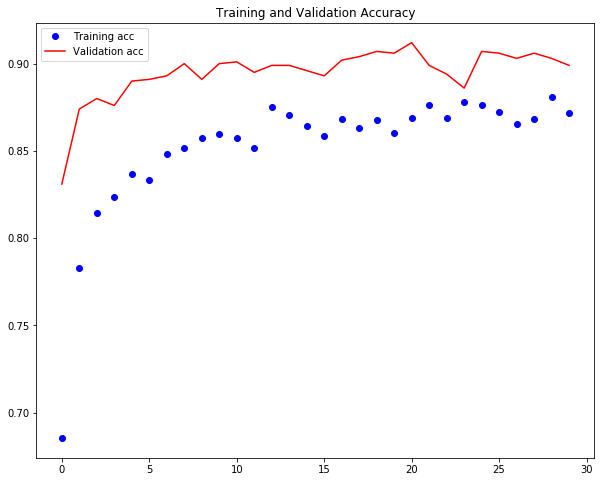

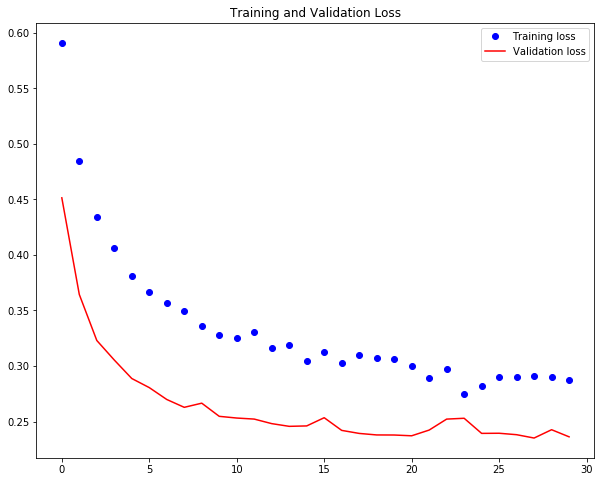

In [38]:
plt.rcParams['figure.figsize'] = (10, 8)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Fine-tuning the last 3 convolutional layers

In [39]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [42]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [6]:
# Adding 'conv_base' to a Sequential model
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 9,732,929
Trainable params: 2,097,665
Non-trainable params: 7,635,264
_________________________________________________________________


C:\Users\admin\Anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [44]:
# model compile
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [46]:
# fitting model
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=100, 
    validation_data=validation_generator, 
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 17s 175ms/step - loss: 0.2914 - acc: 0.8760 - val_loss: 0.2155 - val_acc: 0.9100
Epoch 2/100
100/100 [==============================] - 16s 161ms/step - loss: 0.2798 - acc: 0.8805 - val_loss: 0.1980 - val_acc: 0.9210
Epoch 3/100
100/100 [==============================] - 16s 162ms/step - loss: 0.2332 - acc: 0.8990 - val_loss: 0.2053 - val_acc: 0.9190
Epoch 4/100
100/100 [==============================] - 16s 159ms/step - loss: 0.2212 - acc: 0.9090 - val_loss: 0.2005 - val_acc: 0.9170
Epoch 5/100
100/100 [==============================] - 16s 157ms/step - loss: 0.2106 - acc: 0.9105 - val_loss: 0.1937 - val_acc: 0.9240
Epoch 6/100
100/100 [==============================] - 16s 160ms/step - loss: 0.1899 - acc: 0.9210 - val_loss: 0.2132 - val_acc: 0.9230
Epoch 7/100
100/100 [==============================] - 16s 158ms/step - loss: 0.1868 - acc: 0.9215 - val_loss: 0.2055 - val_acc: 0.9200
Epoch 8/100
100/100 [===========================

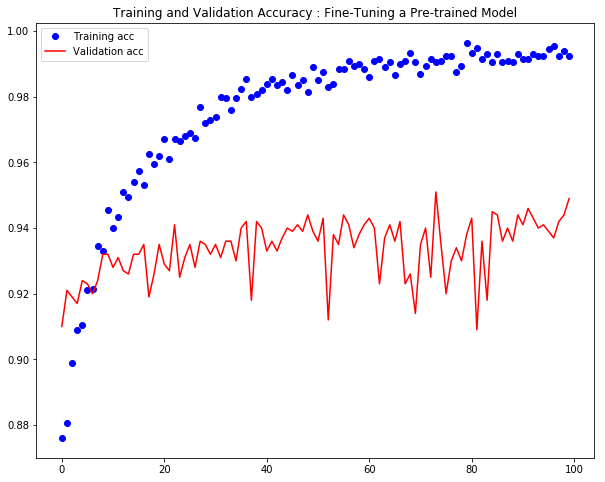

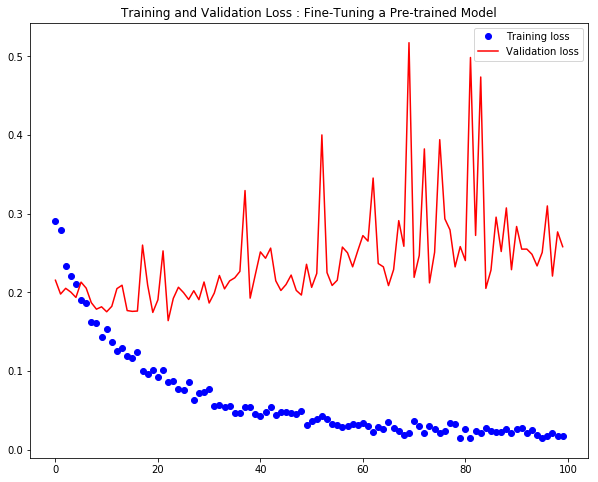

In [49]:
# plot the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.rcParams['figure.figsize'] = (10, 8)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy : Fine-Tuning a Pre-trained Model')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss : Fine-Tuning a Pre-trained Model')
plt.legend()

plt.show()

In [50]:
# Smoothing by replacing every loss and accuracy with exponential moving averages
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

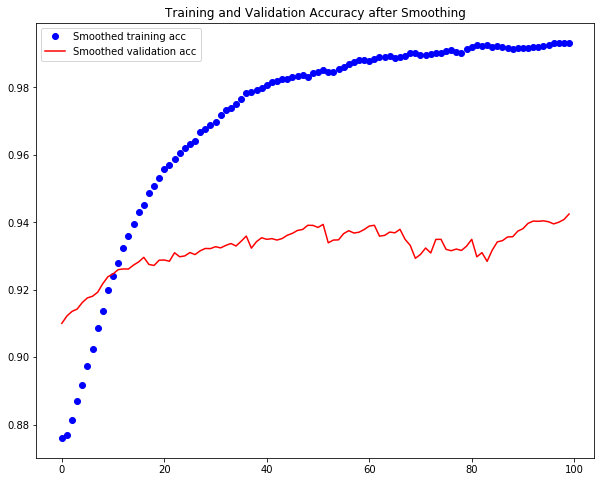

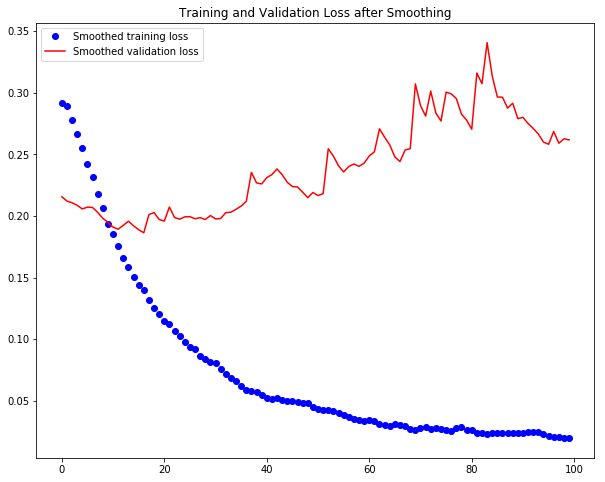

In [51]:
plt.rcParams['figure.figsize'] = (10, 8)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and Validation Accuracy after Smoothing')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and Validation Loss after Smoothing')
plt.legend()

plt.show()

In [54]:
np.argmin(val_loss)

22

In [55]:
# fitting model
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=22, 
    validation_data=validation_generator, 
    validation_steps=50)

Epoch 1/22
100/100 [==============================] - 18s 175ms/step - loss: 0.0175 - acc: 0.9940 - val_loss: 0.2170 - val_acc: 0.9470
Epoch 2/22
100/100 [==============================] - 16s 160ms/step - loss: 0.0185 - acc: 0.9950 - val_loss: 0.2614 - val_acc: 0.9410
Epoch 3/22
100/100 [==============================] - 16s 158ms/step - loss: 0.0169 - acc: 0.9950 - val_loss: 0.3071 - val_acc: 0.9330
Epoch 4/22
100/100 [==============================] - 16s 156ms/step - loss: 0.0136 - acc: 0.9960 - val_loss: 0.4069 - val_acc: 0.9300
Epoch 5/22
100/100 [==============================] - 16s 156ms/step - loss: 0.0214 - acc: 0.9940 - val_loss: 0.2837 - val_acc: 0.9400
Epoch 6/22
100/100 [==============================] - 16s 155ms/step - loss: 0.0204 - acc: 0.9940 - val_loss: 0.2527 - val_acc: 0.9380
Epoch 7/22
100/100 [==============================] - 16s 158ms/step - loss: 0.0205 - acc: 0.9925 - val_loss: 0.2831 - val_acc: 0.9310
Epoch 8/22
100/100 [==============================] - 1

In [56]:
# evaluate this model on the test data
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

print('test acc: ', test_acc)
print('test loss: ', test_loss)

Found 1000 images belonging to 2 classes.
test acc:  0.9419999921321869
test loss:  0.38731714740528334


In [57]:
# save model
model.save('cats_and_dogs_small_4.h5')